In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [3]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install supervision==0.6.0 roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-sns45n8t
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-sns45n8t
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=f4c57feba56688acc22952e1a8d1a9abe697bbefdd6ce9f79dfd70e66e65efe7
  Stored in directory: /tmp/pip-ephem-wheel-cache-guytu61u/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 8.1 MB/s eta 0:

In [4]:
!mkdir -p weights
%cd weights
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
%cd ..

/content/weights
--2023-05-04 23:54:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.27, 52.84.251.15, 52.84.251.106, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   230MB/s    in 10s     

2023-05-04 23:54:51 (239 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

/content


In [3]:
import os

SAM_CHECKPOINT_PATH = os.path.join("weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

weights/sam_vit_h_4b8939.pth ; exist: True


In [4]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from segment_anything import sam_model_registry, SamPredictor

SAM_ENCODER_VERSION = "vit_h"

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [7]:
!mkdir -p data
%cd data

/content/data


In [8]:
from roboflow import Roboflow
rf = Roboflow(api_key="xL7AkWLQA3VIEYLGTJPR")
project = rf.workspace("aml-nxhac").project("aml-cdhom")
dataset = project.version(4).download("voc")

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to aml-4 in voc:: 100%|██████████| 311/311 [00:00<00:00, 483.35it/s]


In [9]:
!mkdir -p voc/imgs
!mkdir -p voc/anns
!mv aml-4/test/*.xml voc/anns
!mv aml-4/train/*.xml voc/anns
!mv aml-4/valid/*.xml voc/anns
!mv aml-4/test/* voc/imgs
!mv aml-4/train/* voc/imgs
!mv aml-4/valid/* voc/imgs

In [11]:
import supervision as sv

dataset = sv.Dataset.from_pascal_voc('voc/imgs', 'voc/anns')

In [12]:
dataset.classes

['pepper', 'charger']

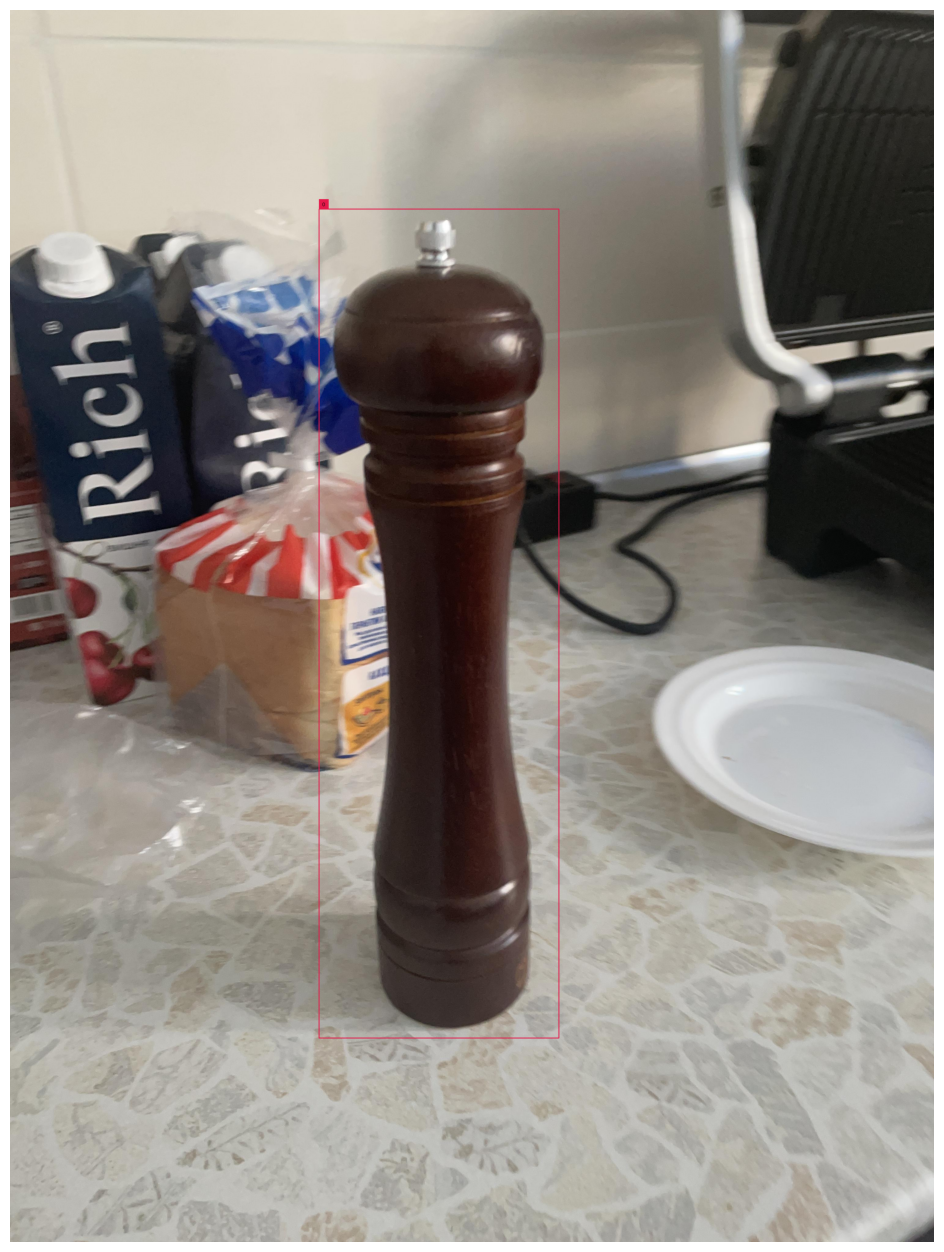

In [13]:
# load image
image = dataset.images['IMG_5132_JPG.rf.712bd8b50a50049e57fc33d809785c4c.jpg']

# detect objects
detections = dataset.annotations['IMG_5132_JPG.rf.712bd8b50a50049e57fc33d809785c4c.jpg']

# annotate image with detections
box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=dataset.classes)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [15]:
import numpy as np

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

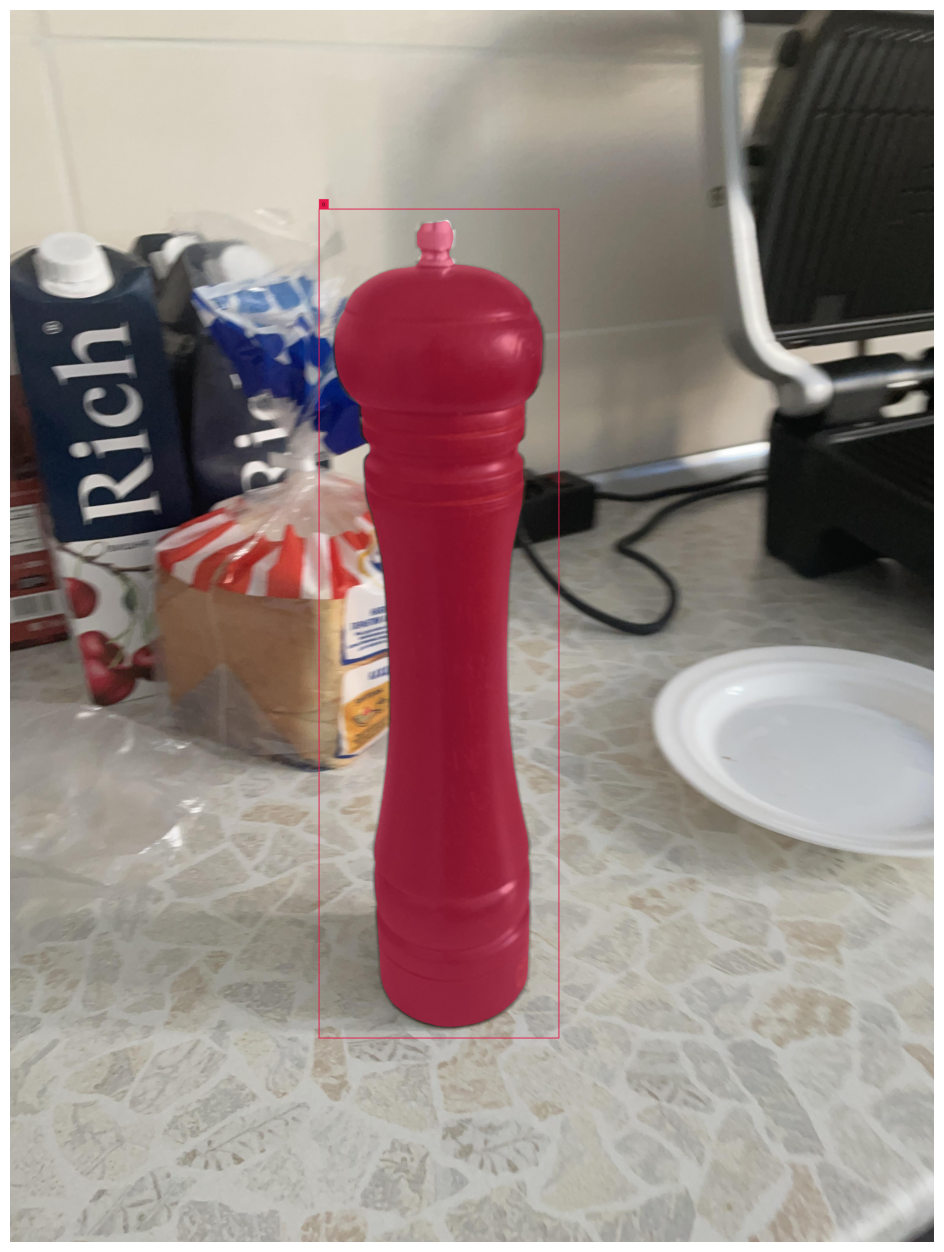

In [16]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

In [17]:
import cv2
from tqdm.notebook import tqdm


for image_path in tqdm(dataset.annotations):
    image = dataset.images[image_path]

    detections = dataset.annotations[image_path]
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

  0%|          | 0/153 [00:00<?, ?it/s]

In [37]:
!mkdir -p new_voc/imgs
!mkdir -p new_voc/anns

In [38]:
dataset.as_pascal_voc('new_voc/imgs', 'new_voc/anns')

In [39]:
!zip -r new_voc.zip new_voc

  adding: new_voc/ (stored 0%)
  adding: new_voc/anns/ (stored 0%)
  adding: new_voc/anns/IMG_5373_JPG.rf.de25ed3c76a5f098c0ba35f1782efd75.xml (deflated 70%)
  adding: new_voc/anns/IMG_5485_JPG.rf.096fa21b6213a6406ea4706b7d16acd3.xml (deflated 70%)
  adding: new_voc/anns/IMG_5139_JPG.rf.c8199d679fcb86e9bb37a2a0b970dba0.xml (deflated 70%)
  adding: new_voc/anns/IMG_5422_JPG.rf.ff97759c515b557aec19b93bbd7d6ec2.xml (deflated 70%)
  adding: new_voc/anns/IMG_5223_JPG.rf.6b0b0b61d6e3c2dc2da63ba30fef74e4.xml (deflated 71%)
  adding: new_voc/anns/IMG_5219_JPG.rf.c941770322ceb06bdd85d1cd5ebdf973.xml (deflated 70%)
  adding: new_voc/anns/IMG_5324_JPG.rf.9dc40de75a92af8f4ce5e2c74f856db5.xml (deflated 70%)
  adding: new_voc/anns/IMG_5124_JPG.rf.d5516e950270cd1371316ff561eb866e.xml (deflated 70%)
  adding: new_voc/anns/IMG_5144_JPG.rf.8b5eaa9a6e6786713708bca92c85422f.xml (deflated 70%)
  adding: new_voc/anns/IMG_5578_JPG.rf.5cddfb22774d2b8d4319e8e61de5c259.xml (deflated 70%)
  adding: new_voc/anns/